In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from matplotlib import rcParams, pyplot as plt
import numpy as np
import os
import pandas as pd
from pathlib import Path
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, GlobalMaxPooling1D, Conv1D, Dropout, Bidirectional, MaxPooling1D, Flatten
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model, to_categorical
from tensorflow.keras.optimizers import Adam
import warnings 
warnings.filterwarnings(action='ignore')

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU
    try:
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)
else:
    print('No GPU detected')

No GPU detected


In [5]:
rcParams['figure.figsize'] = (16, 8)
plt.style.use('fivethirtyeight')
pd.set_option('max_columns', 100)
pd.set_option("display.precision", 4)
warnings.simplefilter('ignore')

In [10]:
data_dir = Path("drive/My Drive/data")
feature_dir = Path("drive/My Drive/data")
val_dir = Path('drive/My Drive/data')
tst_dir = Path('drive/My Drive/data')
sub_dir = Path('drive/My Drive/data')
dirs = [feature_dir, val_dir, tst_dir, sub_dir]
for d in dirs:
  os.makedirs(d,exist_ok=True)

trn_file = data_dir / 'train.csv'
tst_file = data_dir / 'test_x.csv'
sample_file = data_dir/ 'sample_submission.csv'
glove_file = data_dir / 'glove.6B.100d.txt'

target_col = 'author'
n_fold = 5
n_class = 5
seed = 42

In [7]:
algo_name = 'cnn'
feature_name = 'lstm'
model_name = f'{algo_name}_{feature_name}'

feature_file = feature_dir / f'{feature_name}.csv'
p_val_file = val_dir / f'{model_name}.val.csv'
p_tst_file = tst_dir / f'{model_name}.tst.csv'
sub_file = sub_dir / f'{model_name}.csv'

In [11]:
train = pd.read_csv(trn_file, index_col=0)
train.head()

,text,author
index,,
0,"He was almost choking. There was so much, so m...",3
1,"“Your sister asked for it, I suppose?”",2
2,"She was engaged one day as she walked, in per...",1
3,"The captain was in the porch, keeping himself ...",4
4,"“Have mercy, gentlemen!” odin flung up his han...",3


In [12]:
test = pd.read_csv(tst_file, index_col=0)
test.head()

,text
index,
0,“Not at all. I think she is one of the most ch...
1,"""No,"" replied he, with sudden consciousness, ""..."
2,As the lady had stated her intention of scream...
3,“And then suddenly in the silence I heard a so...
4,His conviction remained unchanged. So far as I...


In [13]:
def alpha_num(text):
    return re.sub(r'[^A-Za-z0-9 ]', '', text)


def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopwords:
            final_text.append(i.strip())
    return " ".join(final_text)


stopwords = [ "a", "to", "the", "and", "of", "I" ]

In [14]:
train['text'] = train['text'].str.lower().apply(alpha_num).apply(remove_stopwords)
test['text'] = test['text'].str.lower().apply(alpha_num).apply(remove_stopwords)

In [15]:
X_train = train['text'].values
X_test = test['text'].values
y = train['author'].values
print(X_train.shape, X_test.shape, y.shape)

(54879,) (19617,) (54879,)


In [16]:
X_train[:3]

array(['he was almost choking there was so much so much he wanted say but strange exclamations were all that came from his lips pole gazed fixedly at him at bundle notes in his hand looked at odin was in evident perplexity',
       'your sister asked for it i suppose',
       'she was engaged one day as she walked in perusing janes last letter dwelling on some passages which proved that jane had not written in spirits when instead being again surprised by mr odin she saw on looking up that odin was meeting her putting away letter immediately forcing smile she said'],
      dtype=object)

In [17]:
vocab_size = 20000
embedding_dim = 64
max_length = 500
padding_type='post'

In [18]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [19]:
train_sequences = tokenizer.texts_to_sequences(X_train)
test_sequences = tokenizer.texts_to_sequences(X_test)

In [20]:
trn = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length)
tst = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length)
print(trn.shape, tst.shape)

(54879, 500) (19617, 500)


In [21]:
cv = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=seed)

In [42]:
def get_model():
    model = Sequential([
        Embedding(vocab_size, embedding_dim, input_length=max_length),
        Dropout(0.3),
        Conv1D(64, 4, padding="same", activation="relu", strides=3),
        MaxPooling1D(pool_size=3),
        Dropout(0.3),
        LSTM(32, return_sequences=True),
        Flatten(),
        Dense(n_class, activation='softmax')
    ])
    
    # compile model
    model.compile(loss='categorical_crossentropy',
                  optimizer=Adam(learning_rate=.005))
    return model

In [43]:
p_val = np.zeros((trn.shape[0], n_class))
p_tst = np.zeros((tst.shape[0], n_class))
for i, (i_trn, i_val) in enumerate(cv.split(trn, y), 1):
    print(f'training model for CV #{i}')
    es = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=3,
                       verbose=1, mode='min', baseline=None, restore_best_weights=True)

    clf = get_model()    
    clf.fit(trn[i_trn], 
            to_categorical(y[i_trn]),
            validation_data=(trn[i_val], to_categorical(y[i_val])),
            epochs=10,
            batch_size=512,
            callbacks=[es])
    p_val[i_val, :] = clf.predict(trn[i_val])
    p_tst += clf.predict(tst) / n_fold

training model for CV #1
Epoch 1/10
86/86 [==============================] - 52s 608ms/step - loss: 1.2340 - val_loss: 0.8938
Epoch 2/10
86/86 [==============================] - 52s 607ms/step - loss: 0.7341 - val_loss: 0.7560
Epoch 3/10
86/86 [==============================] - 52s 605ms/step - loss: 0.5201 - val_loss: 0.7418
Epoch 4/10
86/86 [==============================] - 52s 606ms/step - loss: 0.4133 - val_loss: 0.8044
Epoch 5/10
86/86 [==============================] - 52s 602ms/step - loss: 0.3472 - val_loss: 0.8182
Epoch 6/10
86/86 [==============================] - 52s 607ms/step - loss: 0.3028 - val_loss: 0.8869
Epoch 00006: early stopping
training model for CV #2
Epoch 1/10
86/86 [==============================] - 52s 603ms/step - loss: 1.2252 - val_loss: 0.8782
Epoch 2/10
86/86 [==============================] - 51s 590ms/step - loss: 0.7111 - val_loss: 0.7092
Epoch 3/10
86/86 [==============================] - 51s 587ms/step - loss: 0.5038 - val_loss: 0.7154
Epoch 4/10
86

In [44]:
print(f'Accuracy (CV): {accuracy_score(y, np.argmax(p_val, axis=1)) * 100:8.4f}%')
print(f'Log Loss (CV): {log_loss(pd.get_dummies(y), p_val):8.4f}')

Accuracy (CV):  73.8643%
Log Loss (CV):   0.7061


In [45]:
np.savetxt(p_val_file, p_val, fmt='%.6f', delimiter=',')
np.savetxt(p_tst_file, p_tst, fmt='%.6f', delimiter=',')

In [46]:
print(clf.summary())

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 500, 64)           1280000   
_________________________________________________________________
dropout_21 (Dropout)         (None, 500, 64)           0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 167, 64)           16448     
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 55, 64)            0         
_________________________________________________________________
dropout_22 (Dropout)         (None, 55, 64)            0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 55, 32)            12416     
_________________________________________________________________
flatten_8 (Flatten)          (None, 1760)            

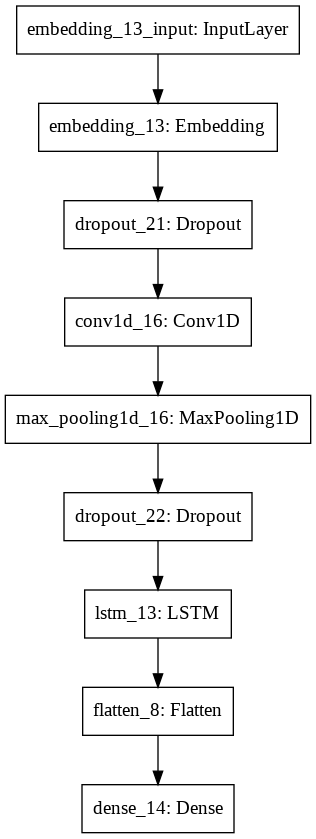

In [47]:
plot_model(clf)

In [48]:
sub = pd.read_csv(sample_file, index_col=0)
print(sub.shape)
sub.head()

(19617, 5)


,0,1,2,3,4
index,,,,,
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0


In [49]:
sub[sub.columns] = p_tst
sub.head()

,0,1,2,3,4
index,,,,,
0,0.0283,0.8234,0.1134,0.0312,0.0037
1,0.3076,0.5056,0.0219,0.0052,0.1597
2,0.9673,0.0263,0.0019,0.0002,0.0043
3,0.0011,0.0006,0.9195,0.0016,0.0771
4,0.7941,0.0227,0.0078,0.1137,0.0616


In [51]:
sub.to_csv(sub_file)